# Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import shutil
import wandb
import matplotlib.pyplot as plt

from wandb.keras import WandbMetricsLogger, WandbCallback

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

from keras import backend as K



# Loading and preprocess the dataset

In [2]:
koniq10k_directory = '/media/workstation/BackupDrive/Dataset/koniq10k/'
ori_img_dir = koniq10k_directory + 'koniq10k_1024x768_ori/'

# read in scores from koniq_10k
data_mos = pd.read_csv(koniq10k_directory + 'koniq10k_scores_and_distributions/koniq10k_scores_and_distributions.csv')
data_mos_set = pd.read_csv(koniq10k_directory + 'koniq10k_scores_and_distributions/koniq10k_distributions_sets.csv')
set_column = data_mos_set['set']

data_mos['set'] = set_column
display(data_mos)


,image_name,c1,c2,c3,c4,c5,c_total,MOS,SD,MOS_zscore,set
0,10004473376.jpg,0,0,25,73,7,105,3.828571,0.527278,77.383621,training
1,10007357496.jpg,0,3,45,47,1,96,3.479167,0.580003,68.728571,test
2,10007903636.jpg,1,0,20,73,2,96,3.781250,0.527220,78.628571,training
3,10009096245.jpg,0,0,21,75,13,109,3.926606,0.556218,77.243750,training
4,100117038.jpg,0,1,21,72,6,100,3.830000,0.532860,75.112500,training
...,...,...,...,...,...,...,...,...,...,...,...
10068,9984535544.jpg,0,0,46,55,3,104,3.586538,0.550562,70.020089,test
10069,9991658304.jpg,0,1,12,85,6,104,3.923077,0.455651,79.337838,training
10070,9991999836.jpg,0,0,15,79,7,101,3.920792,0.462237,78.092437,test
10071,9995874256.jpg,0,3,53,51,1,108,3.462963,0.570717,68.095133,training


### Convert the images in the files to 512x* with mogrify

mogrify -resize 512x /*.jpg

### Split images into train-validation-test directories (70% - 10% - 20%)

In [3]:
# Select the images for training-validation-testing
img_dir = koniq10k_directory + 'koniq10k_512x_image_in_csv/'

data_mos_train = data_mos[data_mos['set'] == 'training']
display(data_mos_train)

data_mos_val = data_mos[data_mos['set'] == 'validation']
display(data_mos_val)

data_mos_test = data_mos[data_mos['set'] == 'test']
display(data_mos_test)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=data_mos_train, 
    directory=img_dir, 
    x_col="image_name", 
    y_col="MOS", 
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=32
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=data_mos_test, 
    directory=img_dir, 
    x_col="image_name", 
    y_col="MOS", 
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=32
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=data_mos_val, 
    directory=img_dir, 
    x_col="image_name", 
    y_col="MOS", 
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=32
)

,image_name,c1,c2,c3,c4,c5,c_total,MOS,SD,MOS_zscore,set
0,10004473376.jpg,0,0,25,73,7,105,3.828571,0.527278,77.383621,training
2,10007903636.jpg,1,0,20,73,2,96,3.781250,0.527220,78.628571,training
3,10009096245.jpg,0,0,21,75,13,109,3.926606,0.556218,77.243750,training
4,100117038.jpg,0,1,21,72,6,100,3.830000,0.532860,75.112500,training
5,10012398043.jpg,0,7,55,40,1,103,3.339806,0.619193,65.149533,training
...,...,...,...,...,...,...,...,...,...,...,...
10064,9975733946.jpg,0,3,50,56,3,112,3.526786,0.599697,69.185897,training
10067,9978257554.jpg,0,2,52,49,2,105,3.485714,0.573691,67.600000,training
10069,9991658304.jpg,0,1,12,85,6,104,3.923077,0.455651,79.337838,training
10071,9995874256.jpg,0,3,53,51,1,108,3.462963,0.570717,68.095133,training


,image_name,c1,c2,c3,c4,c5,c_total,MOS,SD,MOS_zscore,set
20,10043785683.jpg,0,0,46,60,0,106,3.566038,0.497974,71.204327,validation
25,10059344614.jpg,0,3,46,49,2,100,3.500000,0.594588,68.665138,validation
26,10061596254.jpg,0,8,74,25,0,107,3.158879,0.534640,59.641892,validation
27,10067457634.jpg,0,0,15,87,7,109,3.926606,0.445272,78.439076,validation
36,10082923485.jpg,0,16,77,11,0,104,2.951923,0.509708,53.226087,validation
...,...,...,...,...,...,...,...,...,...,...,...
10027,9895678845.jpg,0,3,81,16,1,101,3.148515,0.455766,57.747664,validation
10052,9941134286.jpg,0,2,55,50,1,108,3.462963,0.554100,65.904867,validation
10056,9945099433.jpg,3,30,81,11,0,125,2.800000,0.622171,50.432927,validation
10058,9954707815.jpg,2,20,60,26,0,108,3.018519,0.710160,56.163136,validation


,image_name,c1,c2,c3,c4,c5,c_total,MOS,SD,MOS_zscore,set
1,10007357496.jpg,0,3,45,47,1,96,3.479167,0.580003,68.728571,test
9,10020766793.jpg,0,0,11,78,20,109,4.082569,0.529298,81.506250,test
10,10020891105.jpg,0,4,80,18,0,102,3.137255,0.445866,56.829741,test
11,10022757465.jpg,0,3,32,66,4,105,3.676190,0.596387,71.015487,test
18,10039534103.jpg,0,0,34,72,1,107,3.691589,0.483915,76.075000,test
...,...,...,...,...,...,...,...,...,...,...,...
10050,9936084895.jpg,0,5,63,30,0,98,3.255102,0.543210,61.648649,test
10065,9977056676.jpg,0,34,64,5,0,103,2.718447,0.549821,46.301339,test
10066,9977191265.jpg,0,1,44,58,5,108,3.620370,0.591491,74.471698,test
10068,9984535544.jpg,0,0,46,55,3,104,3.586538,0.550562,70.020089,test


Found 7058 validated image filenames.
Found 2015 validated image filenames.
Found 1000 validated image filenames.


# Model Training (InceptionResNetV2)

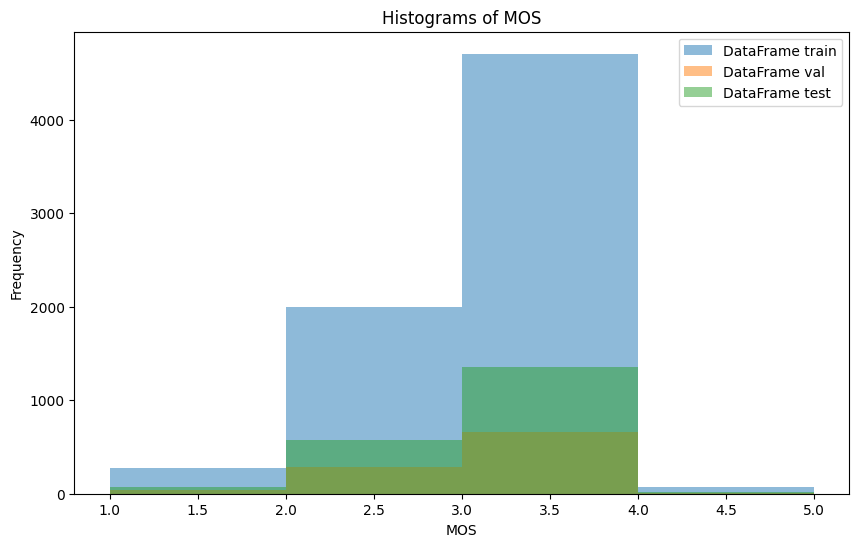

In [4]:
column_name = 'MOS'

# Plot histograms
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# DataFrame 1
plt.hist(data_mos_train[column_name], bins=4, alpha=0.5, range=(1,5), label='DataFrame train')

# DataFrame 2
plt.hist(data_mos_val[column_name], bins=4, alpha=0.5, range=(1,5), label='DataFrame val')

# DataFrame 3
plt.hist(data_mos_test[column_name], bins=4, alpha=0.5, range=(1,5), label='DataFrame test')

plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.title('Histograms of ' + column_name)
plt.legend()
plt.show()


## wandb configs

### Create the PLCC custom metric first

In [5]:
def plcc_tf(x, y):
    """PLCC metric"""
    xc = x - K.mean(x)
    yc = y - K.mean(y)
    return K.mean(xc*yc)/(K.std(x)*K.std(y) + K.epsilon())

def pearson_correlation(y_true, y_pred):
    # Subtract the mean from true and predicted values
    y_true_mean = K.mean(y_true)
    y_pred_mean = K.mean(y_pred)
    y_true_centered = y_true - y_true_mean
    y_pred_centered = y_pred - y_pred_mean

    # Calculate covariance and standard deviation
    covariance = K.mean(y_true_centered * y_pred_centered)
    y_true_std = K.std(y_true)
    y_pred_std = K.std(y_pred)

    # Calculate Pearson correlation coefficient
    pearson_coefficient = covariance / (y_true_std * y_pred_std + K.epsilon())

    return pearson_coefficient

In [6]:
class CustomMetricCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Calculate the custom metric
        y_true = self.validation_data[1]
        y_pred = self.model.predict(self.validation_data[0])
        pearson_coefficient = pearson_correlation(y_true, y_pred)

        # Log the custom metric using wandb
        wandb.log({"val_pearson_coefficient": pearson_coefficient})

In [7]:
wandb.init(
    # set the wandb project where this run will be logged
    project="baseline_koniq_quality",
    dir = "/media/workstation/BackupDrive/wandb_files/logs",

    # track hyperparameters and run metadata with wandb.config
    config={
        "fc1" : 2048,
        "activation1" : 'relu',
        "dropout1": 0.25,
        "fc2" : 1024,
        "activation2" : 'relu',
        "dropout2": 0.25,
        "fc3" : 256,
        "activation3" : 'relu',
        "dropout3": 0.5,
        "fc4" : 1,
        "activation4" : 'linear',
        "dropout4": 0,
        "learning_rate" : 0.001,
        "optimizer": "adam",
        "loss": "mean_squared_error",
        "metric": "root mean_squared_error",
        "epoch": 100,
        "batch_size": 32,
        "metric2" : "val_pearson_correlation",
        "early_patience" : 20,
        "early_mode" : 'max',
        "early_min_delta" : 0.001,
        "plateau_patience" : 5,
        "plateau_mode" : "max",
        "plateau_factor" : 0.2,
        "plateau_min_lr" : 0.000001,
        "plateau_min_delta" : 0.01
    }
)

config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ianchoo2000. Use `wandb login --relogin` to force relogin


In [8]:
# Load the InceptionResNetV2 model without pre-trained weights
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add your own top layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(config.fc1, activation=config.activation1)(x)
x = BatchNormalization()(x)
x = Dropout(config.dropout1)(x)

x = Dense(config.fc2, activation=config.activation2)(x)
x = BatchNormalization()(x)
x = Dropout(config.dropout2)(x)

x = Dense(config.fc3, activation=config.activation3)(x)
x = BatchNormalization()(x)
x = Dropout(config.dropout3)(x)

predictions = Dense(config.fc4, activation=config.activation4)(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

optimizer = keras.optimizers.Adam(learning_rate=config.learning_rate)

# Compile the model
model.compile(optimizer=optimizer,
              loss=config.loss,
              metrics=[tf.keras.metrics.RootMeanSquaredError(), pearson_correlation]
              )

checkpoint_filepath = '/media/workstation/BackupDrive/Dataset/koniq10k/koniq10k_512x_checkpoint/'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_pearson_correlation',
    mode='max'
    )

early_stopping_callback = EarlyStopping(
    monitor= config.metric2, 
    patience=config.early_patience,
    mode=config.early_mode,
    min_delta = config.early_min_delta
    )

reduce_lr_callback = ReduceLROnPlateau(
    monitor = config.metric2,
    factor = config.plateau_factor,
    patience = config.plateau_patience,
    mode = config.plateau_mode,
    min_lr = config.plateau_min_lr
)


2023-07-08 14:27:49.877928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-08 14:27:49.883075: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-08 14:27:49.883248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-08 14:27:49.884183: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
# Train the model with the preprocessed data
history = model.fit(train_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    epochs = config.epoch,
                    validation_data = val_generator,
                    validation_steps = val_generator.n//val_generator.batch_size,
                    callbacks = [
                      WandbMetricsLogger(log_freq=5),
                      WandbCallback(monitor='val_pearson_correlation', mode='max', save_model=False, save_weights_only=False),
                      model_checkpoint_callback,
                      early_stopping_callback,
                      reduce_lr_callback
                    ])

wandb.finish()

Epoch 1/100


2023-07-08 14:28:46.982180: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


220/220 [==============================] - 308s 1s/step - loss: 5.2903 - mean_absolute_error: 1.8012 - pearson_correlation: 0.0992 - val_loss: 1.7735 - val_mean_absolute_error: 0.9307 - val_pearson_correlation: -0.0048 - lr: 0.0010
Epoch 2/100
220/220 [==============================] - 83s 376ms/step - loss: 1.7177 - mean_absolute_error: 0.8843 - pearson_correlation: 0.1537 - val_loss: 0.2560 - val_mean_absolute_error: 0.3914 - val_pearson_correlation: 0.4525 - lr: 0.0010
Epoch 3/100
220/220 [==============================] - 86s 389ms/step - loss: 1.1486 - mean_absolute_error: 0.6989 - pearson_correlation: 0.2611 - val_loss: 1.1249 - val_mean_absolute_error: 0.5389 - val_pearson_correlation: 0.3842 - lr: 0.0010
Epoch 4/100
220/220 [==============================] - 84s 383ms/step - loss: 0.9124 - mean_absolute_error: 0.6249 - pearson_correlation: 0.3022 - val_loss: 0.1652 - val_mean_absolute_error: 0.3313 - val_pearson_correlation: 0.6670 - lr: 0.0010
Epoch 5/100
220/220 [============

batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,███████████████████████████▂▂▂▂▁▁▁▁▁▁▁▁▁
batch/loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/pearson_correlation,▁▁▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇███████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,███████████████████████████▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/pearson_correlation,▁▁▂▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████████████


In [7]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=data_mos_test, 
    directory=img_dir, 
    x_col="image_name", 
    y_col="MOS", 
    shuffle = False,
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=32
)

Found 2015 validated image filenames.


In [88]:
# Evaluate the model on the preprocessed test data
evaluation = model.evaluate(
    test_generator,
    steps=len(test_generator)
)

63/63 [==============================] - 6s 101ms/step - loss: 0.0885 - mean_absolute_error: 0.2175 - pearson_correlation: 0.8462


In [58]:
saved_model_path = '/media/workstation/BackupDrive/model/baseline_koniq_quality_likely_eon_32/'

model.save(saved_model_path + 'baseline_koniq_quality_likely_eon_32.h5')
model.save_weights(saved_model_path + 'baseline_koniq_quality_weights_likely_eon_32.h5')

# Predict baseline 

In [89]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=data_mos_test, 
    directory=img_dir, 
    x_col="image_name", 
    y_col="MOS", 
    shuffle = False,
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=1
)

Found 2015 validated image filenames.


In [90]:
import scipy 
from sklearn.metrics import mean_squared_error

def plcc(x, y):
    '''Pearson Linear Correlation Coefficient'''
    x, y = np.float32(x), np.float32(y)
    return scipy.stats.pearsonr(x,y)[0]

def srocc(xs, ys):
    '''Spearman Rank Order Correlation Coefficient'''
    correlation, p_value = scipy.stats.spearmanr(xs, ys)
    return correlation

def rmse(y_test, y_pred):
    mse = np.mean((y_test - y_pred) ** 2)
    return np.sqrt(mse)
    

In [91]:
prediction = model.predict(
    test_generator,
    steps=len(test_generator)
)

SRCC/PLCC 0.818/0.848


Text(0.5, 0.98, 'Quality Score Ground truth - Prediction')

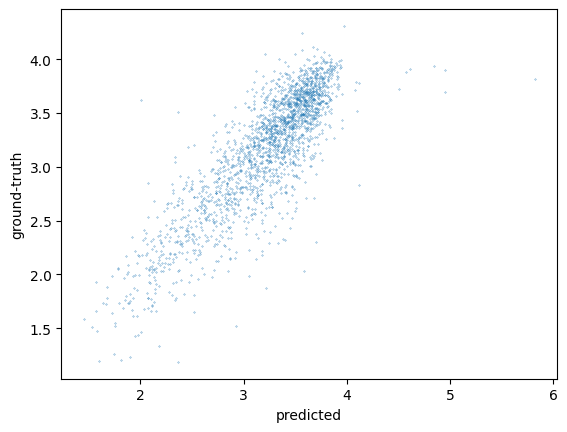

<Figure size 640x480 with 0 Axes>

In [95]:
# prediction
test_list = prediction.tolist()
test_list = [val[0] for val in test_list]
len(test_list)

# data_mos_test
test_1 = data_mos_test.copy()
test_1['pred_value'] = test_list
test_1

y_test = np.array(test_1.loc[:, 'MOS'])
y_pred = np.array(test_1.loc[:, 'pred_value'])

SRCC_test = round(srocc(y_pred, y_test), 3)
PLCC_test = round(plcc(y_pred, y_test), 3)
print('SRCC/PLCC {}/{}'.format(SRCC_test, PLCC_test))

plt.plot(y_pred, y_test, '.', markersize=0.5)
plt.xlabel('predicted'); plt.ylabel('ground-truth'); plt.show
fig = plt.figure()
fig.suptitle('Quality Score Ground truth - Prediction')